In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas 
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
import seaborn as sns
csv = './openpowerlifting-2020-09-06.csv'
df = pandas.read_csv(csv,index_col=0,low_memory=False)
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0, 'Mx': -1})
df['Equipment'] = df['Equipment'].map({'Single-ply':0, 'Raw':1, 'Wraps':2, 'Unlimited':3, 'Multi-ply':4})
data = df[['Sex','BodyweightKg', 'Best3SquatKg', 'Best3DeadliftKg','Age','Equipment', 'Best3BenchKg']].dropna(how='any')


In [17]:
men = data[data['Sex'] == 1]
data_men = pandas.melt(men)
data_men['Sex'] = 'Men'
women = data[data['Sex'] == 0]
data_women = pandas.melt(women)
data_women['Sex'] = 'Women'
data_allsex = pandas.concat([data_men, data_women], axis=0)

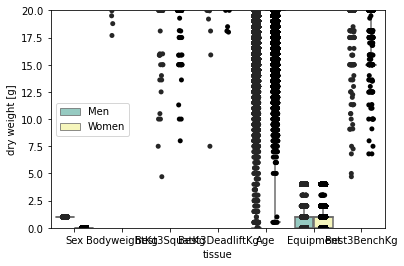

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(x='variable', y='value', data=data_allsex, hue='Sex', showfliers=False, palette='Set3', ax=ax)
sns.stripplot(x='variable', y='value', data=data_allsex, hue='Sex', dodge=True, jitter=True, color='black', ax=ax)
handles, labels = ax.get_legend_handles_labels()

# 4 legends for defaul: boxplot x 2 species, and stripplot x 2 species
# use the first 2 legends
ax.legend(handles[0:2], labels[0:2])
ax.set_xlabel('tissue')
ax.set_ylabel('dry weight [g]')
ax.set_ylim(0, 20)
plt.show()

In [19]:
data.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3DeadliftKg,Age,Equipment,Best3BenchKg
count,681124.000000,681124.000000,681124.000000,681124.000000,681124.000000,681124.000000,681124.000000
mean,0.713565,83.802501,186.043912,201.509187,29.249429,0.917849,120.456135
std,0.452118,22.520136,72.379906,63.652978,12.246909,0.930922,52.389975
min,-1.000000,17.690000,-445.000000,-347.500000,0.000000,0.000000,-362.500000
25%,0.000000,66.900000,130.000000,150.000000,20.000000,0.000000,77.500000
50%,1.000000,81.700000,182.500000,205.000000,25.500000,1.000000,120.000000
75%,1.000000,98.200000,232.500000,249.480000,35.500000,1.000000,155.000000
max,1.000000,250.050000,577.500000,457.500000,95.500000,4.000000,460.000000


In [31]:
data = df[['Sex','BodyweightKg', 'Best3SquatKg', 'Best3DeadliftKg','Age','Equipment', 'Best3BenchKg']].dropna(how='any')
data.head()

,Sex,BodyweightKg,Best3SquatKg,Best3DeadliftKg,Age,Equipment,Best3BenchKg
Name,,,,,,,
Clint Samuels,1,82.5,195.04,249.48,27.5,2.0,138.35
Zach Lerner,1,82.5,183.70,215.46,32.5,2.0,111.13
Sam Cox #2,1,110.0,288.03,317.51,24.0,2.0,163.29
Adam Vediz,1,110.0,226.80,226.80,38.5,2.0,170.10
Michaela Smith,0,75.0,138.35,142.88,27.0,2.0,65.77


In [33]:
data = df[['Sex','BodyweightKg', 'Best3SquatKg', 'Best3DeadliftKg','Age','Equipment', 'Best3BenchKg']].dropna(how='any')
data = data.drop(data[data['Best3SquatKg'] <= 0].index)
data = data.drop(data[data['Best3DeadliftKg'] <= 0].index)
data = data.drop(data[data['Best3BenchKg'] <= 0].index)
data = data.drop(data[data['Age'] <= 0].index)

In [34]:
data.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3DeadliftKg,Age,Equipment,Best3BenchKg
count,672763.000000,672763.000000,672763.000000,672763.000000,672763.000000,672763.000000,672763.00000
mean,0.712807,83.740372,186.002221,201.680172,29.230592,0.916113,120.42566
std,0.452476,22.491978,71.507402,62.210522,12.248558,0.930631,51.76349
min,-1.000000,17.690000,4.700000,7.500000,0.500000,0.000000,4.70000
25%,0.000000,66.900000,130.000000,150.000000,20.000000,0.000000,77.50000
50%,1.000000,81.650000,182.500000,205.000000,25.500000,1.000000,120.00000
75%,1.000000,98.100000,231.330000,249.480000,35.500000,1.000000,155.00000
max,1.000000,250.050000,577.500000,457.500000,95.500000,4.000000,460.00000


In [35]:
data.count()

Sex                672763
BodyweightKg       672763
Best3SquatKg       672763
Best3DeadliftKg    672763
Age                672763
Equipment          672763
Best3BenchKg       672763
dtype: int64

In [36]:
q1 = data['Best3SquatKg'].describe()['25%']
q3 = data['Best3SquatKg'].describe()['75%']
iqr = q3 - q1
outlier_min = q1 - (iqr) * 1.5
outlier_max = q3 + (iqr) * 1.5
print( outlier_min, outlier_max)
# data = data.drop(data[data['Best3SquatKg'] <= 0].index)
# data = data.drop(data[data['Best3SquatKg'] >= 386.25].index)
# data['Best3SquatKg'].describe()

-21.995000000000005 383.32500000000005
